# cityscapes.py

In [ ]:
# cityscapes.py

# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import glob
import os.path as osp

import cityscapesscripts.helpers.labels as CSLabels
import mmcv
import numpy as np
import pycocotools.mask as maskUtils
from mmengine.fileio import dump
from mmengine.utils import (Timer, mkdir_or_exist, track_parallel_progress,
                            track_progress)


def collect_files(img_dir, gt_dir):
    suffix = 'leftImg8bit.png'
    files = []
    for img_file in glob.glob(osp.join(img_dir, '**/*.png')):
        assert img_file.endswith(suffix), img_file
        inst_file = gt_dir + img_file[
            len(img_dir):-len(suffix)] + 'gtFine_instanceIds.png'
        # Note that labelIds are not converted to trainId for seg map
        segm_file = gt_dir + img_file[
            len(img_dir):-len(suffix)] + 'gtFine_labelIds.png'
        files.append((img_file, inst_file, segm_file))
    assert len(files), f'No images found in {img_dir}'
    print(f'Loaded {len(files)} images from {img_dir}')

    return files


def collect_annotations(files, nproc=1):
    print('Loading annotation images')
    if nproc > 1:
        images = track_parallel_progress(load_img_info, files, nproc=nproc)
    else:
        images = track_progress(load_img_info, files)

    return images


def load_img_info(files):
    img_file, inst_file, segm_file = files
    inst_img = mmcv.imread(inst_file, 'unchanged')
    # ids < 24 are stuff labels (filtering them first is about 5% faster)
    unique_inst_ids = np.unique(inst_img[inst_img >= 24])
    anno_info = []
    for inst_id in unique_inst_ids:
        # For non-crowd annotations, inst_id // 1000 is the label_id
        # Crowd annotations have <1000 instance ids
        label_id = inst_id // 1000 if inst_id >= 1000 else inst_id
        label = CSLabels.id2label[label_id]
        if not label.hasInstances or label.ignoreInEval:
            continue

        category_id = label.id
        iscrowd = int(inst_id < 1000)
        mask = np.asarray(inst_img == inst_id, dtype=np.uint8, order='F')
        mask_rle = maskUtils.encode(mask[:, :, None])[0]

        area = maskUtils.area(mask_rle)
        # convert to COCO style XYWH format
        bbox = maskUtils.toBbox(mask_rle)

        # for json encoding
        mask_rle['counts'] = mask_rle['counts'].decode()

        anno = dict(
            iscrowd=iscrowd,
            category_id=category_id,
            bbox=bbox.tolist(),
            area=area.tolist(),
            segmentation=mask_rle)
        anno_info.append(anno)
    video_name = osp.basename(osp.dirname(img_file))
    img_info = dict(
        # remove img_prefix for filename
        file_name=osp.join(video_name, osp.basename(img_file)),
        height=inst_img.shape[0],
        width=inst_img.shape[1],
        anno_info=anno_info,
        segm_file=osp.join(video_name, osp.basename(segm_file)))

    return img_info


def cvt_annotations(image_infos, out_json_name):
    out_json = dict()
    img_id = 0
    ann_id = 0
    out_json['images'] = []
    out_json['categories'] = []
    out_json['annotations'] = []
    for image_info in image_infos:
        image_info['id'] = img_id
        anno_infos = image_info.pop('anno_info')
        out_json['images'].append(image_info)
        for anno_info in anno_infos:
            anno_info['image_id'] = img_id
            anno_info['id'] = ann_id
            out_json['annotations'].append(anno_info)
            ann_id += 1
        img_id += 1
    for label in CSLabels.labels:
        if label.hasInstances and not label.ignoreInEval:
            cat = dict(id=label.id, name=label.name)
            out_json['categories'].append(cat)

    if len(out_json['annotations']) == 0:
        out_json.pop('annotations')

    dump(out_json, out_json_name)
    return out_json


def parse_args():
    parser = argparse.ArgumentParser(
        description='Convert Cityscapes annotations to COCO format')
    parser.add_argument('cityscapes_path', help='cityscapes data path')
    parser.add_argument('--img-dir', default='leftImg8bit', type=str)
    parser.add_argument('--gt-dir', default='gtFine', type=str)
    parser.add_argument('-o', '--out-dir', help='output path')
    parser.add_argument(
        '--nproc', default=1, type=int, help='number of process')
    args = parser.parse_args()
    return args


def main():
    args = parse_args()
    cityscapes_path = args.cityscapes_path
    out_dir = args.out_dir if args.out_dir else cityscapes_path
    mkdir_or_exist(out_dir)

    img_dir = osp.join(cityscapes_path, args.img_dir)
    gt_dir = osp.join(cityscapes_path, args.gt_dir)

    set_name = dict(
        train='instancesonly_filtered_gtFine_train.json',
        val='instancesonly_filtered_gtFine_val.json',
        test='instancesonly_filtered_gtFine_test.json')

    for split, json_name in set_name.items():
        print(f'Converting {split} into {json_name}')
        with Timer(print_tmpl='It took {}s to convert Cityscapes annotation'):
            files = collect_files(
                osp.join(img_dir, split), osp.join(gt_dir, split))
            image_infos = collect_annotations(files, nproc=args.nproc)
            cvt_annotations(image_infos, osp.join(out_dir, json_name))


if __name__ == '__main__':
    main()


MMDetection에 있는 dataset_converters/cityscapes.py를 사용하여 cityscapes 데이터셋의 json 파일을 COCO 포맷으로 바꾸어 저장하였다.

# MMDetection을 사용하여 학습

In [ ]:
# mask_rcnn-cityscapes.py

_base_ = [
    '../_base_/models/mask-rcnn_r50_fpn.py',
    '../_base_/datasets/cityscapes_instance.py',
    '../_base_/schedules/schedule_1x.py',
    '../_base_/default_runtime.py'
]

dataset_type = 'CocoDataset'
data_root = '/workspace/dataset/cityscapes/'
anno_root = '/workspace/Hyobin/data/cityscapes/'

classes = ('person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle')

data = dict(
    train=dict(
        type=dataset_type,
        img_prefix=data_root + 'leftImg8bit/train/',
        ann_file=data_root + 'annotations/instancesonly_filtered_gtFine_train.json',
        classes=classes),
    val=dict(
        type=dataset_type,
        img_prefix=data_root + 'leftImg8bit/val/',
        ann_file=data_root + 'annotations/instancesonly_filtered_gtFine_val.json',
        classes=classes),
    test=dict(
        type=dataset_type,
        img_prefix=data_root + 'leftImg8bit/test/',
        ann_file=data_root + 'annotations/instancesonly_filtered_gtFine_test.json',
        classes=classes)
)

model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=8),
        mask_head=dict(num_classes=8))
)

runner = dict(type='EpochBasedRunner', max_epochs=12)


* 모델 : ResNet50 + FPN 기반 Mask R-CNN
* 데이터셋 : cityscapes 데이터셋
* schedule : 1x schedule (lr 수정)

기본 Mask R-CNN 모델은 COCO (80개 class) 기반으로 학습되었지만, Cityscapes 데이터셋은 8개의 class이기 때문에 8로 변경하였다.

max_epoch는 12로 설정하여 학습을 진행했으나 시간이 너무 오래 걸려 epoch 1까지 학습된 모델로 test를 돌렸다.

## cityscapes_instance.py

In [ ]:
# dataset settings
dataset_type = 'CityscapesDataset'
data_root = '/workspace/dataset/cityscapes/'
anno_root = '/workspace/Hyobin/data/cityscapes/'

# Example to use different file client
# Method 1: simply set the data root and let the file I/O module
# automatically infer from prefix (not support LMDB and Memcache yet)

# data_root = 's3://openmmlab/datasets/segmentation/cityscapes/'

# Method 2: Use backend_args, file_client_args in versions before 3.0.0rc6
# backend_args = dict(
#     backend='petrel',
#     path_mapping=dict({
#         './data/': 's3://openmmlab/datasets/segmentation/',
#          'data/': 's3://openmmlab/datasets/segmentation/'
#      }))

backend_args = None

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=backend_args),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(
        type='RandomResize',
        scale=[(2048, 800), (2048, 1024)],
        keep_ratio=True),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile', backend_args=backend_args),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),

    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(
        type='PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]

# 데이터로더 설정
train_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    batch_sampler=dict(type='AspectRatioBatchSampler'),
    dataset=dict(
        type='RepeatDataset',
        times=8,
        dataset=dict(
            type=dataset_type,
            data_root=data_root,
            ann_file=anno_root + 'annotations/instancesonly_filtered_gtFine_train.json',
            data_prefix=dict(img='leftImg8bit/train/'),
            filter_cfg=dict(filter_empty_gt=True, min_size=32),
            pipeline=train_pipeline,
            backend_args=backend_args)))

val_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file=anno_root + 'annotations/instancesonly_filtered_gtFine_val.json',
        data_prefix=dict(img='leftImg8bit/val/'),
        test_mode=True,
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=test_pipeline,
        backend_args=backend_args))


val_evaluator = [
    dict(
        type='CocoMetric',
        ann_file=anno_root + 'annotations/instancesonly_filtered_gtFine_val.json',
        metric=['bbox', 'segm'],
        backend_args=backend_args),
    dict(
        type='CityScapesMetric',
        seg_prefix=anno_root + 'gtFine/val',
        outfile_prefix='./work_dirs/cityscapes_metric/instance',
        backend_args=backend_args)
]




# inference on test dataset and
# format the output results for submission.
test_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file=anno_root + 'annotations/instancesonly_filtered_gtFine_test.json',
        data_prefix=dict(img='leftImg8bit/test/'),
        test_mode=True,
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=test_pipeline))
test_evaluator = dict(
        type='CityScapesMetric',
        format_only=True,
        outfile_prefix='./work_dirs/cityscapes_metric/test')


cityscapes_instance.py는 기본적으로 제공되는 코드에서 data_root와 anno_root를 바꾸어 사용하였다.

## schedule_1x.py

In [ ]:
# training schedule for 1x
train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=12, val_interval=1)
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')

# learning rate
param_scheduler = [
    dict(
        type='LinearLR', start_factor=0.001, by_epoch=False, begin=0, end=500),
    dict(
        type='MultiStepLR',
        begin=0,
        end=12,
        by_epoch=True,
        milestones=[8, 11],
        gamma=0.1)
]

# optimizer
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='SGD', lr=0.001, momentum=0.9, weight_decay=0.0001))

# Default setting for scaling LR automatically
#   - `enable` means enable scaling LR automatically
#       or not by default.
#   - `base_batch_size` = (8 GPUs) x (2 samples per GPU).
auto_scale_lr = dict(enable=False, base_batch_size=16)


학습 스케줄은 1x schedule을 그대로 사용했을 때 학습 중에 loss가 nan이 떠서 lr을 0.02에서 0.001로 바꾸어 사용했다.

# train & test

train과 test는 MMdetection에서 제공한 train.py와 test.py를 사용했다.

## train.py

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import os
import os.path as osp

from mmengine.config import Config, DictAction
from mmengine.registry import RUNNERS
from mmengine.runner import Runner

from mmdet.utils import setup_cache_size_limit_of_dynamo


def parse_args():
    parser = argparse.ArgumentParser(description='Train a detector')
    parser.add_argument('config', help='train config file path')
    parser.add_argument('--work-dir', help='the dir to save logs and models')
    parser.add_argument(
        '--amp',
        action='store_true',
        default=False,
        help='enable automatic-mixed-precision training')
    parser.add_argument(
        '--auto-scale-lr',
        action='store_true',
        help='enable automatically scaling LR.')
    parser.add_argument(
        '--resume',
        nargs='?',
        type=str,
        const='auto',
        help='If specify checkpoint path, resume from it, while if not '
        'specify, try to auto resume from the latest checkpoint '
        'in the work directory.')
    parser.add_argument(
        '--cfg-options',
        nargs='+',
        action=DictAction,
        help='override some settings in the used config, the key-value pair '
        'in xxx=yyy format will be merged into config file. If the value to '
        'be overwritten is a list, it should be like key="[a,b]" or key=a,b '
        'It also allows nested list/tuple values, e.g. key="[(a,b),(c,d)]" '
        'Note that the quotation marks are necessary and that no white space '
        'is allowed.')
    parser.add_argument(
        '--launcher',
        choices=['none', 'pytorch', 'slurm', 'mpi'],
        default='none',
        help='job launcher')
    # When using PyTorch version >= 2.0.0, the `torch.distributed.launch`
    # will pass the `--local-rank` parameter to `tools/train.py` instead
    # of `--local_rank`.
    parser.add_argument('--local_rank', '--local-rank', type=int, default=0)
    args = parser.parse_args()
    if 'LOCAL_RANK' not in os.environ:
        os.environ['LOCAL_RANK'] = str(args.local_rank)

    return args


def main():
    args = parse_args()

    # Reduce the number of repeated compilations and improve
    # training speed.
    setup_cache_size_limit_of_dynamo()

    # load config
    cfg = Config.fromfile(args.config)
    cfg.launcher = args.launcher
    if args.cfg_options is not None:
        cfg.merge_from_dict(args.cfg_options)

    # work_dir is determined in this priority: CLI > segment in file > filename
    if args.work_dir is not None:
        # update configs according to CLI args if args.work_dir is not None
        cfg.work_dir = args.work_dir
    elif cfg.get('work_dir', None) is None:
        # use config filename as default work_dir if cfg.work_dir is None
        cfg.work_dir = osp.join('./work_dirs',
                                osp.splitext(osp.basename(args.config))[0])

    # enable automatic-mixed-precision training
    if args.amp is True:
        cfg.optim_wrapper.type = 'AmpOptimWrapper'
        cfg.optim_wrapper.loss_scale = 'dynamic'

    # enable automatically scaling LR
    if args.auto_scale_lr:
        if 'auto_scale_lr' in cfg and \
                'enable' in cfg.auto_scale_lr and \
                'base_batch_size' in cfg.auto_scale_lr:
            cfg.auto_scale_lr.enable = True
        else:
            raise RuntimeError('Can not find "auto_scale_lr" or '
                               '"auto_scale_lr.enable" or '
                               '"auto_scale_lr.base_batch_size" in your'
                               ' configuration file.')

    # resume is determined in this priority: resume from > auto_resume
    if args.resume == 'auto':
        cfg.resume = True
        cfg.load_from = None
    elif args.resume is not None:
        cfg.resume = True
        cfg.load_from = args.resume

    # build the runner from config
    if 'runner_type' not in cfg:
        # build the default runner
        runner = Runner.from_cfg(cfg)
    else:
        # build customized runner from the registry
        # if 'runner_type' is set in the cfg
        runner = RUNNERS.build(cfg)

    # start training
    runner.train()


if __name__ == '__main__':
    main()


### train log

...생략...

2025/03/13 13:39:15 - mmengine - INFO - Epoch(train)  [1][23550/23720]  lr: 1.0000e-03  eta: 1 day, 0:27:04  time: 0.3449  data_time: 0.0893  memory: 4349  loss: 1.2108  loss_rpn_cls: 0.0376  loss_rpn_bbox: 0.1025  loss_cls: 0.2980  acc: 88.0859  loss_bbox: 0.4400  loss_mask: 0.3328

2025/03/13 13:39:31 - mmengine - INFO - Epoch(train)  [1][23600/23720]  lr: 1.0000e-03  eta: 1 day, 0:26:45  time: 0.3339  data_time: 0.0828  memory: 4349  loss: 1.1043  loss_rpn_cls: 0.0232  loss_rpn_bbox: 0.0762  loss_cls: 0.2816  acc: 85.7422  loss_bbox: 0.4006  loss_mask: 0.3226

2025/03/13 13:39:49 - mmengine - INFO - Epoch(train)  [1][23650/23720]  lr: 1.0000e-03  eta: 1 day, 0:26:38  time: 0.3552  data_time: 0.0990  memory: 4349  loss: 1.1098  loss_rpn_cls: 0.0227  loss_rpn_bbox: 0.0815  loss_cls: 0.2746  acc: 94.9219  loss_bbox: 0.4152  loss_mask: 0.3159

2025/03/13 13:40:06 - mmengine - INFO - Epoch(train)  [1][23700/23720]  lr: 1.0000e-03  eta: 1 day, 0:26:24  time: 0.3420  data_time: 0.0885  memory: 4349  loss: 1.2211  loss_rpn_cls: 0.0241  loss_rpn_bbox: 0.1018  loss_cls: 0.3139  acc: 85.5469  loss_bbox: 0.4453  loss_mask: 0.3360

...생략...

2025/03/13 14:11:04 - mmengine - INFO - Epoch(val) [1][500/500]    coco/bbox_mAP: 0.2820  coco/bbox_mAP_50: 0.5260  coco/bbox_mAP_75: 0.2680  coco/bbox_mAP_s: 0.1460  coco/bbox_mAP_m: 0.3280  coco/bbox_mAP_l: 0.4110  coco/segm_mAP: 0.2110  coco/segm_mAP_50: 0.4550  coco/segm_mAP_75: 0.1680  coco/segm_mAP_s: 0.0660  coco/segm_mAP_m: 0.2240  coco/segm_mAP_l: 0.3430  cityscapes/mAP: 0.2079  cityscapes/AP@50: 0.4566  data_time: 0.4901  time: 1.8275


* 학습 성능: 학습 중 손실 값은 점차 줄어들고 있으며, 정확도는 85%~94%로, 모델이 잘 학습되고 있음을 알 수 있다.
* val 성능: val에서의 mAP는 약 28%로, 모델이 꽤나 좋은 성능을 보이고 있습니다. 특히, bbox와 segmentation 모두에서 꽤 나은 성능을 보입니다. 그러나 Cityscapes 데이터셋에서는 성능이 조금 떨어진다. 이는 Cityscapes 데이터셋의 특성상 학습이 더 많이 필요할 수 있다는 의미일 수 있다.

## test.py

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import os
import os.path as osp
import warnings
from copy import deepcopy

from mmengine import ConfigDict
from mmengine.config import Config, DictAction
from mmengine.runner import Runner

from mmdet.engine.hooks.utils import trigger_visualization_hook
from mmdet.evaluation import DumpDetResults
from mmdet.registry import RUNNERS
from mmdet.utils import setup_cache_size_limit_of_dynamo


# TODO: support fuse_conv_bn and format_only
def parse_args():
    parser = argparse.ArgumentParser(
        description='MMDet test (and eval) a model')
    parser.add_argument('config', help='test config file path')
    parser.add_argument('checkpoint', help='checkpoint file')
    parser.add_argument(
        '--work-dir',
        help='the directory to save the file containing evaluation metrics')
    parser.add_argument(
        '--out',
        type=str,
        help='dump predictions to a pickle file for offline evaluation')
    parser.add_argument(
        '--show', action='store_true', help='show prediction results')
    parser.add_argument(
        '--show-dir',
        help='directory where painted images will be saved. '
        'If specified, it will be automatically saved '
        'to the work_dir/timestamp/show_dir')
    parser.add_argument(
        '--wait-time', type=float, default=2, help='the interval of show (s)')
    parser.add_argument(
        '--cfg-options',
        nargs='+',
        action=DictAction,
        help='override some settings in the used config, the key-value pair '
        'in xxx=yyy format will be merged into config file. If the value to '
        'be overwritten is a list, it should be like key="[a,b]" or key=a,b '
        'It also allows nested list/tuple values, e.g. key="[(a,b),(c,d)]" '
        'Note that the quotation marks are necessary and that no white space '
        'is allowed.')
    parser.add_argument(
        '--launcher',
        choices=['none', 'pytorch', 'slurm', 'mpi'],
        default='none',
        help='job launcher')
    parser.add_argument('--tta', action='store_true')
    # When using PyTorch version >= 2.0.0, the `torch.distributed.launch`
    # will pass the `--local-rank` parameter to `tools/train.py` instead
    # of `--local_rank`.
    parser.add_argument('--local_rank', '--local-rank', type=int, default=0)
    args = parser.parse_args()
    if 'LOCAL_RANK' not in os.environ:
        os.environ['LOCAL_RANK'] = str(args.local_rank)
    return args


def main():
    args = parse_args()

    # Reduce the number of repeated compilations and improve
    # testing speed.
    setup_cache_size_limit_of_dynamo()

    # load config
    cfg = Config.fromfile(args.config)
    cfg.launcher = args.launcher
    if args.cfg_options is not None:
        cfg.merge_from_dict(args.cfg_options)

    # work_dir is determined in this priority: CLI > segment in file > filename
    if args.work_dir is not None:
        # update configs according to CLI args if args.work_dir is not None
        cfg.work_dir = args.work_dir
    elif cfg.get('work_dir', None) is None:
        # use config filename as default work_dir if cfg.work_dir is None
        cfg.work_dir = osp.join('./work_dirs',
                                osp.splitext(osp.basename(args.config))[0])

    cfg.load_from = args.checkpoint

    if args.show or args.show_dir:
        cfg = trigger_visualization_hook(cfg, args)

    if args.tta:

        if 'tta_model' not in cfg:
            warnings.warn('Cannot find ``tta_model`` in config, '
                          'we will set it as default.')
            cfg.tta_model = dict(
                type='DetTTAModel',
                tta_cfg=dict(
                    nms=dict(type='nms', iou_threshold=0.5), max_per_img=100))
        if 'tta_pipeline' not in cfg:
            warnings.warn('Cannot find ``tta_pipeline`` in config, '
                          'we will set it as default.')
            test_data_cfg = cfg.test_dataloader.dataset
            while 'dataset' in test_data_cfg:
                test_data_cfg = test_data_cfg['dataset']
            cfg.tta_pipeline = deepcopy(test_data_cfg.pipeline)
            flip_tta = dict(
                type='TestTimeAug',
                transforms=[
                    [
                        dict(type='RandomFlip', prob=1.),
                        dict(type='RandomFlip', prob=0.)
                    ],
                    [
                        dict(
                            type='PackDetInputs',
                            meta_keys=('img_id', 'img_path', 'ori_shape',
                                       'img_shape', 'scale_factor', 'flip',
                                       'flip_direction'))
                    ],
                ])
            cfg.tta_pipeline[-1] = flip_tta
        cfg.model = ConfigDict(**cfg.tta_model, module=cfg.model)
        cfg.test_dataloader.dataset.pipeline = cfg.tta_pipeline

    # build the runner from config
    if 'runner_type' not in cfg:
        # build the default runner
        runner = Runner.from_cfg(cfg)
    else:
        # build customized runner from the registry
        # if 'runner_type' is set in the cfg
        runner = RUNNERS.build(cfg)

    # add `DumpResults` dummy metric
    if args.out is not None:
        assert args.out.endswith(('.pkl', '.pickle')), \
            'The dump file must be a pkl file.'
        runner.test_evaluator.metrics.append(
            DumpDetResults(out_file_path=args.out))

    # start testing
    runner.test()


if __name__ == '__main__':
    main()


### test log (예측 이미지 생성)

...생략...

2025/03/13 18:06:09 - mmengine - INFO - Epoch(test) [1000/1525]    eta: 0:29:57  time: 3.3355  data_time: 2.7069  memory: 2998  
2025/03/13 18:09:19 - mmengine - INFO - Epoch(test) [1050/1525]    eta: 0:27:14  time: 3.8092  data_time: 3.0340  memory: 2998  
2025/03/13 18:12:05 - mmengine - INFO - Epoch(test) [1100/1525]    eta: 0:24:20  time: 3.3205  data_time: 2.6817  memory: 2998  
2025/03/13 18:15:03 - mmengine - INFO - Epoch(test) [1150/1525]    eta: 0:21:30  time: 3.5502  data_time: 2.8615  memory: 2998  
2025/03/13 18:18:12 - mmengine - INFO - Epoch(test) [1200/1525]    eta: 0:18:42  time: 3.7711  data_time: 3.0058  memory: 2998  
2025/03/13 18:21:46 - mmengine - INFO - Epoch(test) [1250/1525]    eta: 0:15:59  time: 4.2953  data_time: 3.3731  memory: 2998  
2025/03/13 18:24:55 - mmengine - INFO - Epoch(test) [1300/1525]    eta: 0:13:07  time: 3.7801  data_time: 3.0104  memory: 2998  
2025/03/13 18:28:01 - mmengine - INFO - Epoch(test) [1350/1525]    eta: 0:10:13  time: 3.7147  data_time: 2.9871  memory: 2998  
2025/03/13 18:31:09 - mmengine - INFO - Epoch(test) [1400/1525]    eta: 0:07:19  time: 3.7645  data_time: 3.0203  memory: 2998  
2025/03/13 18:34:19 - mmengine - INFO - Epoch(test) [1450/1525]    eta: 0:04:24  time: 3.8176  data_time: 3.0406  memory: 2998  
2025/03/13 18:37:38 - mmengine - INFO - Epoch(test) [1500/1525]    eta: 0:01:28  time: 3.9698  data_time: 3.1790  memory: 2998  
2025/03/13 18:39:13 - mmengine - INFO - results are saved to ./work_dirs/cityscapes_metric/test \n
2025/03/13 18:39:13 - mmengine - INFO - Epoch(test) [1525/1525]    data_time: 2.8531  time: 3.5465

# 예측 이미지 시각화

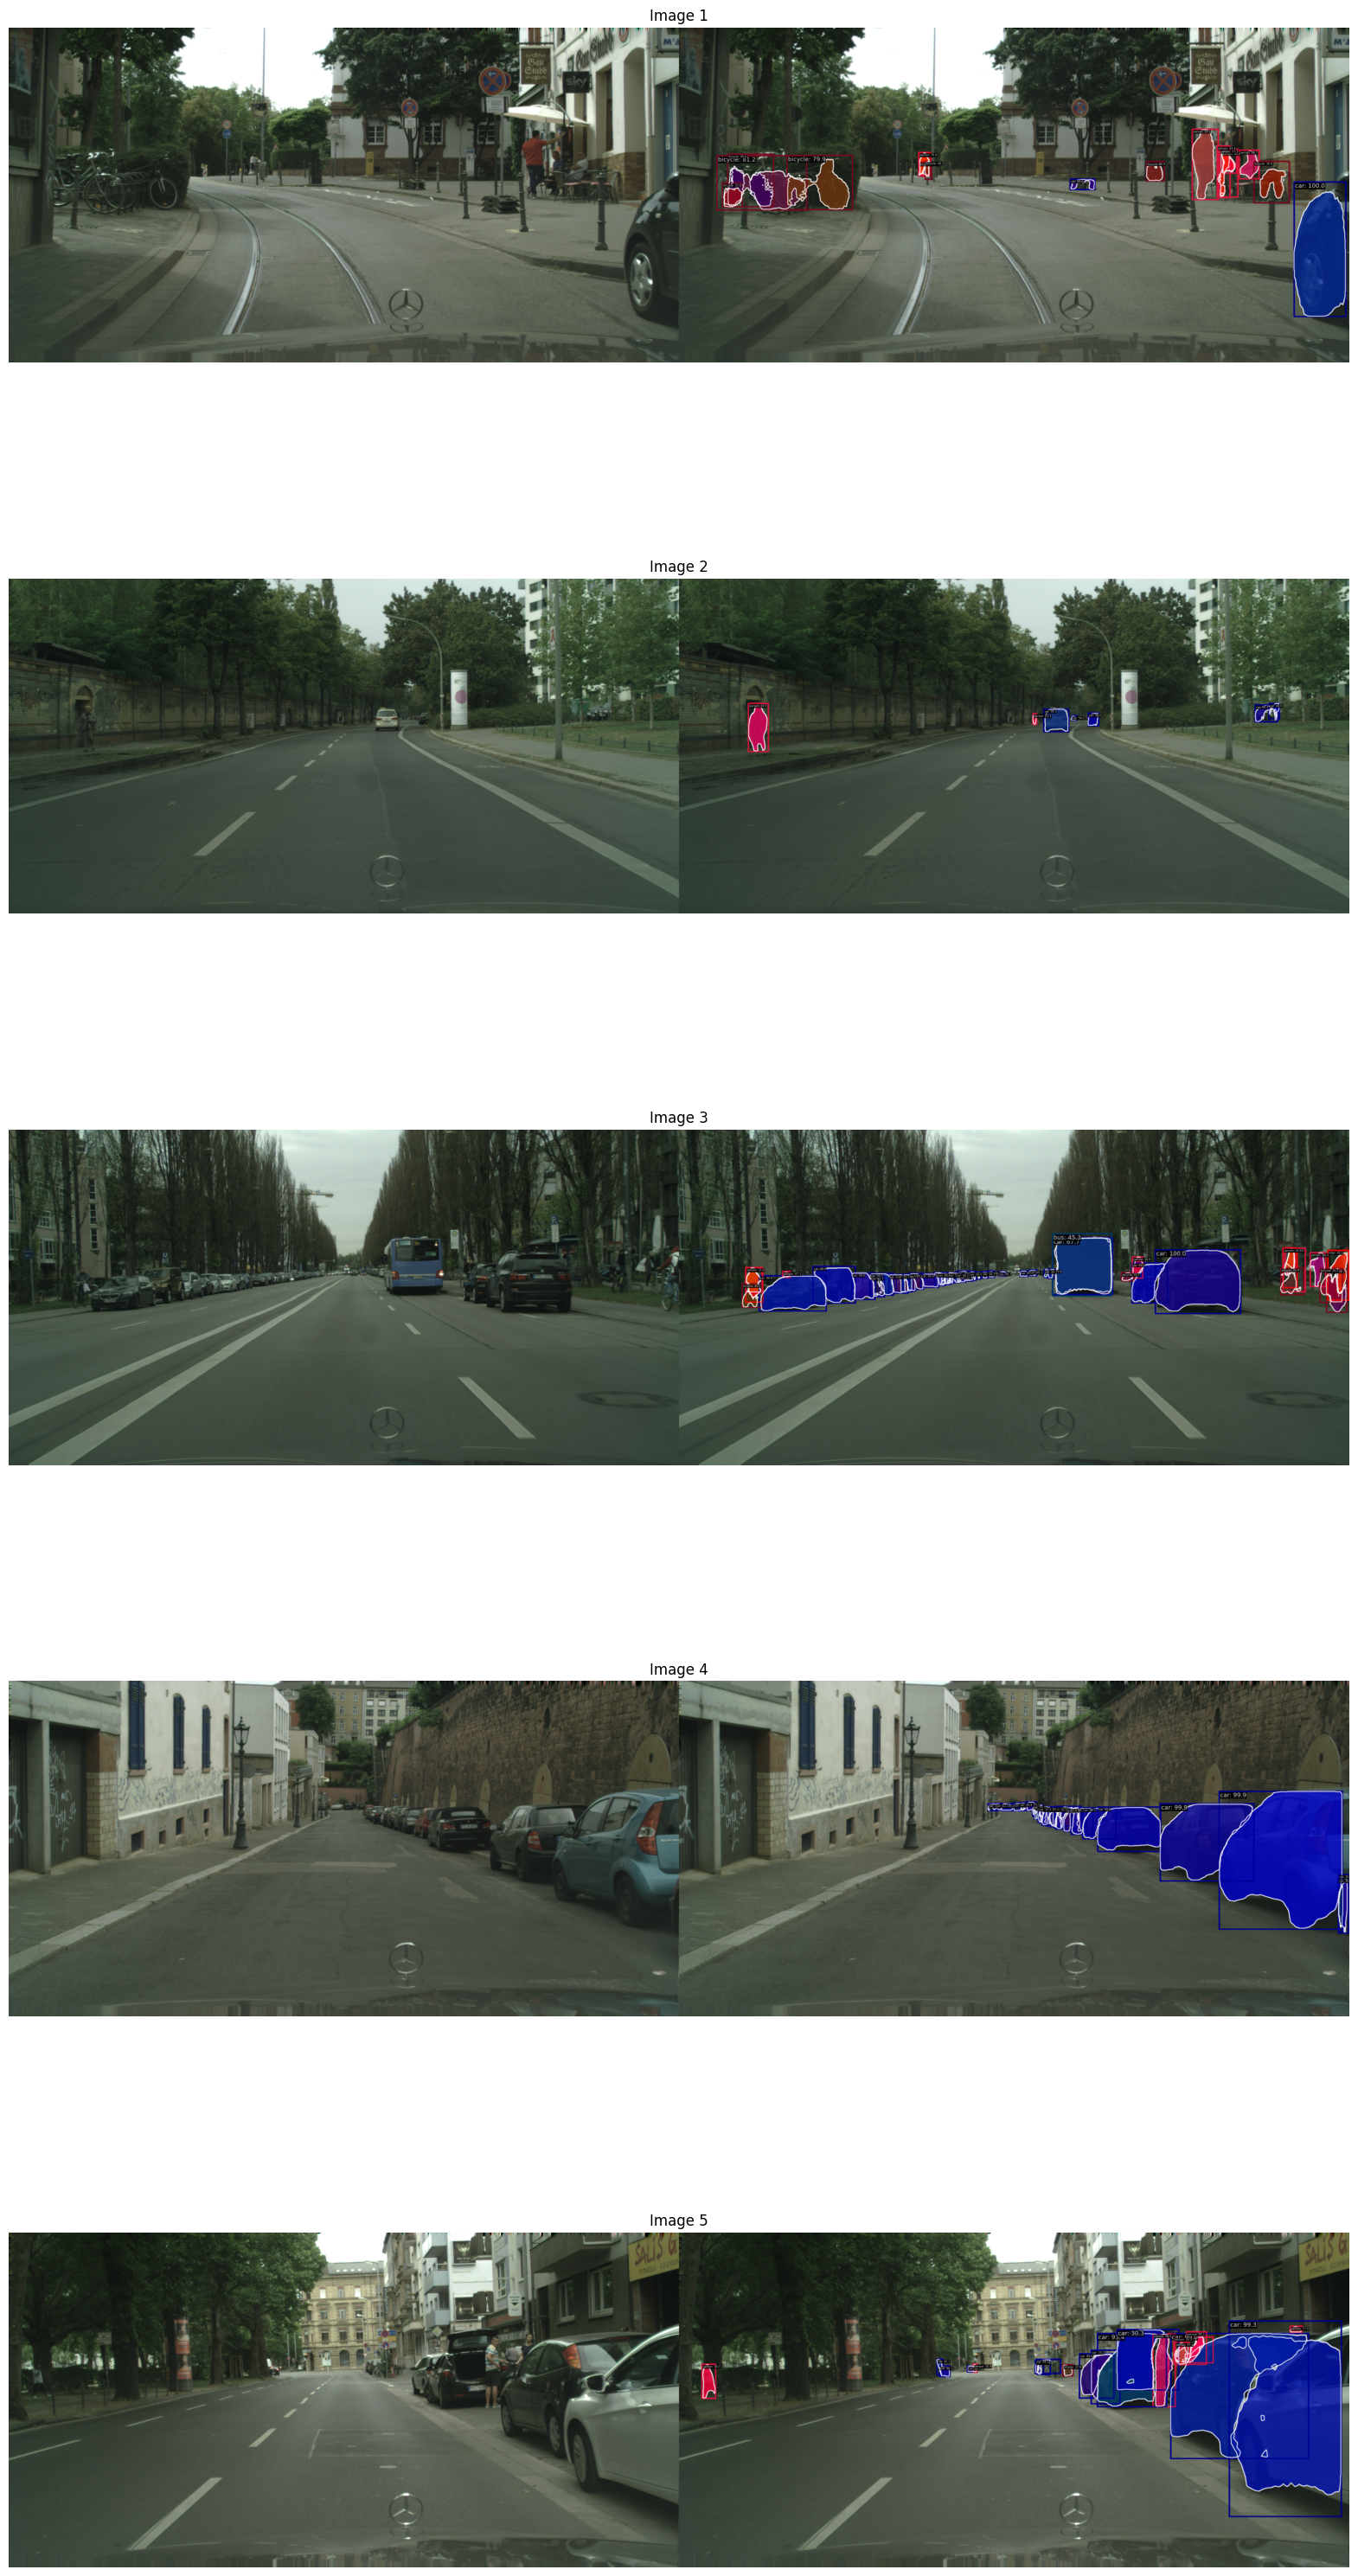

In [10]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 디렉토리 경로 설정
image_dir = 'mmdetection/work_dirs/mask_rcnn-cityscapes/20250313_170852/work_dirs/mask_rcnn-cityscapes/show_results_test/'

# 디렉토리 내 png 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# 무작위로 5개의 이미지 파일 선택
random_images = random.sample(image_files, 5)

# 이미지 시각화
plt.figure(figsize=(20, 40))

for i, img_file in enumerate(random_images):
    img_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(5, 1, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.show()


테스트 결과 이미지를 확인해보면, 모델이 instance segmentation을 나쁘지 않게 수행한 것을 확인할 수 있다.

하지만 겹치는 객체들에 대한 경계 추정에서는 정확도가 떨어지는 모습을 보였다. 이는 모델이 객체들 간의 경계를 잘 구별하지 못한 것으로 해석될 수 있다. 1 epcoh만으로는 모델일 충분히 학습될 시간이 부족했을 것이다. 따라서 더 많은 epoch을 사용하여 학습을 진행해본 후, 그 결과를 비교하는 것이 중요하다. 이렇게 하면, 모델의 경계 추정 성능이 개선되는지 확인할 수 있고, 다른 원인이 있는지 판단할 수 있을 것이다.

# 느낀점

이번 과제에서는 데이터셋을 COCO 포맷으로 변환하는 작업을 진행한 후, MMDetection을 활용하여 학습과 테스트를 수행했다. MMDetection에서 제공하는 코드 덕분에 학습과 테스트하는 과정은 비교적 수월하게 진행할 수 있었다.

하지만 실험을 진행하기 전 환경을 세팅하는 과정에서 어려움을 겪었다. MMDetection은 다양한 의존성과 복잡한 설정이 필요했기 때문에 이를 제대로 설정하는 데 시간이 걸렸다.

이번 실험을 통해 MMDetection을 활용한 학습과 평가의 과정을 익힐 수 있었다. 다만, 객체가 겹치는 부분에서의 경계 인식이 다소 부족했으며, 이는 1 epoch만 학습한 영향이 클 것으로 보인다.

이번에는 단순히 가져다 사용했지만 다음에 사용하게 된다면 MMDetection에 대해 더 자세히 알아보고 사용하는 게 좋을 것 같다.